In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

In [179]:
np.random.seed(42)

# What is the Baseline?

The Y variable is a 50/50 split with each class but if you're going off the throught process that the team with the better win-record wins every single time, you get a success rate of around 68% which is 18% above the baseline. This is shown from this report by [oddsshark](https://www.oddsshark.com/sports-betting/which-sport-do-betting-underdogs-win-most-often). If my model can reach around 68% level effectiveness in the regular season, it will be a tremendous succcess. I am aiming for a cross validation score greater than 65%.

# How are you going to test the model's effectiveness?

I am going to use a 50-50 train-test-split for each given season, while I might be able to get a more accurate predictor from using the entire dataframe and that's what the majority of similar experiments have done, I want to model on an isolated season and see whether the chosen model and feature-set can retain accuracy levels from season to season without any inferrence from the prior season. This is also a way for me to be unique amongst other peers with similar projects as they have used previous season data to assist with the predictive quality of their models.

In [180]:
df = pd.read_csv('./cleaned_data/data_to_model/elo_10_games_full.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [181]:
df

,FG_LAST_10_GAMES_HOME,FGA_LAST_10_GAMES_HOME,FG_PCT_LAST_10_GAMES_HOME,FG(3)_LAST_10_GAMES_HOME,FGA(3)_LAST_10_GAMES_HOME,FG_PCT(3)_LAST_10_GAMES_HOME,FT_LAST_10_GAMES_HOME,FTA_LAST_10_GAMES_HOME,FT_PCT_LAST_10_GAMES_HOME,ORB_LAST_10_GAMES_HOME,...,ELO_AWAY,TEAM_AWAY,ODDS_HOME,GAMEID,GAME_NO_HOME,GAME_NO_AWAY,OTs,DATE,SEASON,HOME_WIN/LABEL
0,36.0,76.0,0.4740,9.0,25.0,0.3600,15.0,24.0,0.6250,14.0,...,1507.214937,DAL,1.716595,201311010HOU,2.0,2.0,0,2013-11-01,2014,1
1,43.0,83.0,0.5180,4.0,19.0,0.2110,14.0,18.0,0.7780,11.0,...,1492.962659,UTA,1.863367,201311010PHO,2.0,2.0,0,2013-11-01,2014,1
2,33.0,81.0,0.4070,8.0,21.0,0.3810,16.0,23.0,0.6960,11.0,...,1490.917957,LAC,1.732959,201311010SAC,2.0,3.0,0,2013-11-01,2014,0
3,38.5,91.0,0.4225,11.0,23.5,0.4635,17.0,24.5,0.7025,13.5,...,1506.235734,SAS,1.562900,201311010LAL,3.0,2.0,0,2013-11-01,2014,0
4,32.0,70.5,0.4540,8.5,20.0,0.4235,23.5,31.0,0.7605,8.0,...,1498.600276,CLE,1.880949,201311020IND,3.0,3.0,0,2013-11-02,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,41.3,91.0,0.4552,10.2,28.7,0.3531,21.7,28.7,0.7545,12.4,...,1336.570066,CHI,6.741837,201904100PHI,82.0,82.0,0,2019-04-10,2019,1
7182,42.9,89.7,0.4794,10.2,28.5,0.3551,14.6,18.7,0.7871,10.4,...,1447.956222,DAL,3.202098,201904100SAS,82.0,82.0,0,2019-04-10,2019,0
7183,39.3,89.2,0.4425,9.0,29.7,0.3015,14.7,19.4,0.7530,9.9,...,1461.666686,MIN,3.598549,201904100DEN,82.0,82.0,0,2019-04-10,2019,1
7184,41.6,84.6,0.4923,11.4,29.4,0.3862,21.2,26.8,0.7927,7.6,...,1627.484293,UTA,0.929183,201904100LAC,82.0,82.0,1,2019-04-10,2019,1


In [182]:
numeric = df._get_numeric_data()
numeric.columns

Index(['FG_LAST_10_GAMES_HOME', 'FGA_LAST_10_GAMES_HOME',
       'FG_PCT_LAST_10_GAMES_HOME', 'FG(3)_LAST_10_GAMES_HOME',
       'FGA(3)_LAST_10_GAMES_HOME', 'FG_PCT(3)_LAST_10_GAMES_HOME',
       'FT_LAST_10_GAMES_HOME', 'FTA_LAST_10_GAMES_HOME',
       'FT_PCT_LAST_10_GAMES_HOME', 'ORB_LAST_10_GAMES_HOME',
       ...
       'CURRENT_TOTAL_LOSSES_AWAY', 'CURRENT_TOTAL_AWAY_WINS_AWAY',
       'CURRENT_TOTAL_AWAY_LOSSES_AWAY', 'ELO_AWAY', 'ODDS_HOME',
       'GAME_NO_HOME', 'GAME_NO_AWAY', 'OTs', 'SEASON', 'HOME_WIN/LABEL'],
      dtype='object', length=104)

In [183]:
numeric['SEASON'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [184]:
_2014_df = numeric.loc[numeric['SEASON'] == 2014]
X1 = _2014_df.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
y1 = _2014_df['HOME_WIN/LABEL']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,random_state=42, shuffle=False, test_size=0.5)
_2015_df = numeric.loc[numeric['SEASON'] == 2015]
X2 = _2015_df.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
y2 = _2015_df['HOME_WIN/LABEL']
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,random_state=42, shuffle=False, test_size=0.5)
_2016_df = numeric.loc[numeric['SEASON'] == 2016]
X3 = _2016_df.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
y3 = _2016_df['HOME_WIN/LABEL']
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,random_state=42, shuffle=False, test_size=0.5)
_2017_df = numeric.loc[numeric['SEASON'] == 2017]
X4 = _2017_df.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
y4 = _2017_df['HOME_WIN/LABEL']
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,random_state=42, shuffle=False, test_size=0.5)
_2018_df = numeric.loc[numeric['SEASON'] == 2018]
X5 = _2018_df.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
y5 = _2018_df['HOME_WIN/LABEL']
X5_train,X5_test,y5_train,y5_test = train_test_split(X5,y5,random_state=42, shuffle=False, test_size=0.5)
_2019_df = numeric.loc[numeric['SEASON'] == 2019]
X6 = _2019_df.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
y6 = _2019_df['HOME_WIN/LABEL']
X6_train,X6_test,y6_train,y6_test = train_test_split(X6,y6,random_state=42, shuffle=False, test_size=0.5)

In [185]:
X1._get_numeric_data().shape, X1.shape

((1199, 102), (1199, 102))

### ML MODELS TO USE:
- LOGISTIC REGRESSION
- DECISION TREE CLASSIFIER
- kNN CLASSIFIER
- BAGGING CLASSIFIER
- RANDOM FOREST CLASSIFIER
- ADABOOST CLASSIFIER
- GRADIENT BOOST CLASSIFIER

In [186]:
mlr_lst = []
dt_lst = []
knn_lst = []
bag_lst = []
rf_lst = []
ada_lst = []
gboost_lst = []

In [187]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X1_train,y1_train)
pipe_knn.fit(X1_train,y1_train)
pipe_dtree.fit(X1_train,y1_train)
pipe_bag.fit(X1_train,y1_train)
pipe_rf.fit(X1_train,y1_train)
pipe_ada.fit(X1_train,y1_train)
pipe_gboost.fit(X1_train,y1_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X1_train,y1_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X1_test,y1_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X1_train,y1_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X1_test,y1_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X1_train,y1_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X1_test,y1_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X1_train,y1_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X1_test,y1_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X1_train,y1_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X1_test,y1_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X1_train,y1_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X1_test,y1_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X1_train,y1_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X1_test,y1_test)}')

mlr_lst.append(pipe_mlr.score(X1_test,y1_test))
knn_lst.append(pipe_knn.score(X1_test,y1_test))
dt_lst.append(pipe_dtree.score(X1_test,y1_test))
bag_lst.append(pipe_bag.score(X1_test,y1_test))
rf_lst.append(pipe_rf.score(X1_test,y1_test))
ada_lst.append(pipe_ada.score(X1_test,y1_test))
gboost_lst.append(pipe_gboost.score(X1_test,y1_test))

Multiple Logistic Regression Train Score is: 0.6327212020033389
Multiple Logistic Regression Test Score is: 0.5166666666666667
K Nearest Neighbors Classifier Train Score is: 0.6894824707846411
K Nearest Neighbors Classifier Test Score is: 0.485
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.52
Bagging Classifier Train Score is: 0.988313856427379
Bagging Classifier Test Score is: 0.4716666666666667
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5033333333333333
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.49666666666666665
Gradient Boost Train Score is: 0.9833055091819699
Gradient Boost Test Score is: 0.5316666666666666


In [188]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X2_train,y2_train)
pipe_knn.fit(X2_train,y2_train)
pipe_dtree.fit(X2_train,y2_train)
pipe_bag.fit(X2_train,y2_train)
pipe_rf.fit(X2_train,y2_train)
pipe_ada.fit(X2_train,y2_train)
pipe_gboost.fit(X2_train,y2_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X2_train,y2_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X2_test,y2_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X2_train,y2_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X2_test,y2_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X2_train,y2_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X2_test,y2_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X2_train,y2_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X2_test,y2_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X2_train,y2_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X2_test,y2_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X2_train,y2_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X2_test,y2_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X2_train,y2_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X2_test,y2_test)}')

mlr_lst.append(pipe_mlr.score(X2_test,y2_test))
knn_lst.append(pipe_knn.score(X2_test,y2_test))
dt_lst.append(pipe_dtree.score(X2_test,y2_test))
bag_lst.append(pipe_bag.score(X2_test,y2_test))
rf_lst.append(pipe_rf.score(X2_test,y2_test))
ada_lst.append(pipe_ada.score(X2_test,y2_test))
gboost_lst.append(pipe_gboost.score(X2_test,y2_test))

Multiple Logistic Regression Train Score is: 0.625
Multiple Logistic Regression Test Score is: 0.49
K Nearest Neighbors Classifier Train Score is: 0.6933333333333334
K Nearest Neighbors Classifier Test Score is: 0.525
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.505
Bagging Classifier Train Score is: 0.98
Bagging Classifier Test Score is: 0.5
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.51
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.51
Gradient Boost Train Score is: 0.9916666666666667
Gradient Boost Test Score is: 0.475


In [189]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X3_train,y3_train)
pipe_knn.fit(X3_train,y3_train)
pipe_dtree.fit(X3_train,y3_train)
pipe_bag.fit(X3_train,y3_train)
pipe_rf.fit(X3_train,y3_train)
pipe_ada.fit(X3_train,y3_train)
pipe_gboost.fit(X3_train,y3_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X3_train,y3_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X3_test,y3_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X3_train,y3_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X3_test,y3_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X3_train,y3_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X3_test,y3_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X3_train,y3_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X3_test,y3_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X3_train,y3_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X3_test,y3_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X3_train,y3_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X3_test,y3_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X3_train,y3_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X3_test,y3_test)}')

mlr_lst.append(pipe_mlr.score(X3_test,y3_test))
knn_lst.append(pipe_knn.score(X3_test,y3_test))
dt_lst.append(pipe_dtree.score(X3_test,y3_test))
bag_lst.append(pipe_bag.score(X3_test,y3_test))
rf_lst.append(pipe_rf.score(X3_test,y3_test))
ada_lst.append(pipe_ada.score(X3_test,y3_test))
gboost_lst.append(pipe_gboost.score(X3_test,y3_test))

Multiple Logistic Regression Train Score is: 0.6622073578595318
Multiple Logistic Regression Test Score is: 0.5384615384615384
K Nearest Neighbors Classifier Train Score is: 0.6989966555183946
K Nearest Neighbors Classifier Test Score is: 0.5050167224080268
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.4882943143812709
Bagging Classifier Train Score is: 0.9782608695652174
Bagging Classifier Test Score is: 0.4916387959866221
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5668896321070234
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.49665551839464883
Gradient Boost Train Score is: 0.9849498327759197
Gradient Boost Test Score is: 0.5150501672240803


In [190]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X4_train,y4_train)
pipe_knn.fit(X4_train,y4_train)
pipe_dtree.fit(X4_train,y4_train)
pipe_bag.fit(X4_train,y4_train)
pipe_rf.fit(X4_train,y4_train)
pipe_ada.fit(X4_train,y4_train)
pipe_gboost.fit(X4_train,y4_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X4_train,y4_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X4_test,y4_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X4_train,y4_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X4_test,y4_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X4_train,y4_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X4_test,y4_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X4_train,y4_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X4_test,y4_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X4_train,y4_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X4_test,y4_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X4_train,y4_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X4_test,y4_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X4_train,y4_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X4_test,y4_test)}')

mlr_lst.append(pipe_mlr.score(X4_test,y4_test))
knn_lst.append(pipe_knn.score(X4_test,y4_test))
dt_lst.append(pipe_dtree.score(X4_test,y4_test))
bag_lst.append(pipe_bag.score(X4_test,y4_test))
rf_lst.append(pipe_rf.score(X4_test,y4_test))
ada_lst.append(pipe_ada.score(X4_test,y4_test))
gboost_lst.append(pipe_gboost.score(X4_test,y4_test))

Multiple Logistic Regression Train Score is: 0.6806020066889632
Multiple Logistic Regression Test Score is: 0.48080133555926546
K Nearest Neighbors Classifier Train Score is: 0.6889632107023411
K Nearest Neighbors Classifier Test Score is: 0.5008347245409015
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.4941569282136895
Bagging Classifier Train Score is: 0.9816053511705686
Bagging Classifier Test Score is: 0.5141903171953256
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5091819699499165
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.48914858096828046
Gradient Boost Train Score is: 0.9916387959866221
Gradient Boost Test Score is: 0.5008347245409015


In [191]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X5_train,y5_train)
pipe_knn.fit(X5_train,y5_train)
pipe_dtree.fit(X5_train,y5_train)
pipe_bag.fit(X5_train,y5_train)
pipe_rf.fit(X5_train,y5_train)
pipe_ada.fit(X5_train,y5_train)
pipe_gboost.fit(X5_train,y5_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X5_train,y5_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X5_test,y5_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X5_train,y5_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X5_test,y5_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X5_train,y5_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X5_test,y5_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X5_train,y5_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X5_test,y5_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X5_train,y5_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X5_test,y5_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X5_train,y5_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X5_test,y5_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X5_train,y5_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X5_test,y5_test)}')

mlr_lst.append(pipe_mlr.score(X5_test,y5_test))
knn_lst.append(pipe_knn.score(X5_test,y5_test))
dt_lst.append(pipe_dtree.score(X5_test,y5_test))
bag_lst.append(pipe_bag.score(X5_test,y5_test))
rf_lst.append(pipe_rf.score(X5_test,y5_test))
ada_lst.append(pipe_ada.score(X5_test,y5_test))
gboost_lst.append(pipe_gboost.score(X5_test,y5_test))

Multiple Logistic Regression Train Score is: 0.6415410385259631
Multiple Logistic Regression Test Score is: 0.49498327759197325
K Nearest Neighbors Classifier Train Score is: 0.7068676716917923
K Nearest Neighbors Classifier Test Score is: 0.5066889632107023
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5484949832775919
Bagging Classifier Train Score is: 0.9782244556113903
Bagging Classifier Test Score is: 0.4782608695652174
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.48327759197324416
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5551839464882943
Gradient Boost Train Score is: 0.983249581239531
Gradient Boost Test Score is: 0.4866220735785953


In [192]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X6_train,y6_train)
pipe_knn.fit(X6_train,y6_train)
pipe_dtree.fit(X6_train,y6_train)
pipe_bag.fit(X6_train,y6_train)
pipe_rf.fit(X6_train,y6_train)
pipe_ada.fit(X6_train,y6_train)
pipe_gboost.fit(X6_train,y6_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X6_train,y6_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X6_test,y6_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X6_train,y6_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X6_test,y6_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X6_train,y6_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X6_test,y6_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X6_train,y6_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X6_test,y6_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X6_train,y6_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X6_test,y6_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X6_train,y6_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X6_test,y6_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X6_train,y6_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X6_test,y6_test)}')

mlr_lst.append(pipe_mlr.score(X6_test,y6_test))
knn_lst.append(pipe_knn.score(X6_test,y6_test))
dt_lst.append(pipe_dtree.score(X6_test,y6_test))
bag_lst.append(pipe_bag.score(X6_test,y6_test))
rf_lst.append(pipe_rf.score(X6_test,y6_test))
ada_lst.append(pipe_ada.score(X6_test,y6_test))
gboost_lst.append(pipe_gboost.score(X6_test,y6_test))

Multiple Logistic Regression Train Score is: 0.6477462437395659
Multiple Logistic Regression Test Score is: 0.5183333333333333
K Nearest Neighbors Classifier Train Score is: 0.6978297161936561
K Nearest Neighbors Classifier Test Score is: 0.5183333333333333
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5
Bagging Classifier Train Score is: 0.9849749582637729
Bagging Classifier Test Score is: 0.48833333333333334
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.52
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.4816666666666667
Gradient Boost Train Score is: 0.991652754590985
Gradient Boost Test Score is: 0.5366666666666666


In [193]:
import statistics as stats

In [194]:
print(f'The logistic regression score: {stats.mean(mlr_lst)}')
print(f'The K nearest neighbors classifier score: {stats.mean(knn_lst)}')
print(f'The decision tree classifier score: {stats.mean(dt_lst)}')
print(f'The bagging classifier score: {stats.mean(bag_lst)}')
print(f'The random forest classifier score: {stats.mean(rf_lst)}')
print(f'The ada boost classifier score: {stats.mean(ada_lst)}')
print(f'The gradient boost classifier score: {stats.mean(gboost_lst)}')

The logistic regression score: 0.5065410252687962
The K nearest neighbors classifier score: 0.5068122905821606
The decision tree classifier score: 0.5093243709787587
The bagging classifier score: 0.49068166379119416
The random forest classifier score: 0.5154470878939196
The ada boost classifier score: 0.5048868965307595
The gradient boost classifier score: 0.5076400497794851


All of these models underperform significantly, likely due to a lot of noise or the train size is not nearly as large as other models. Feature-extraction and hyper-parameter tuning is what I can do for this specific dataset further. Potentially, scaling the data could be a problem but I doubt it would change results significantly. Regardless, I will test the unscaled data anyway.

In [195]:
pipe_mlr = Pipeline([
    ('mlr', LogisticRegression(max_iter=2000))
])

pipe_knn = Pipeline([
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('gboost', GradientBoostingClassifier(random_state=42))
])

mlr_lst = []
knn_lst = []
dt_lst = []
bag_lst = []
rf_lst = []
ada_lst = []
gboost_lst = []

In [196]:
pipe_mlr.fit(X1_train,y1_train)
pipe_knn.fit(X1_train,y1_train)
pipe_dtree.fit(X1_train,y1_train)
pipe_bag.fit(X1_train,y1_train)
pipe_rf.fit(X1_train,y1_train)
pipe_ada.fit(X1_train,y1_train)
pipe_gboost.fit(X1_train,y1_train)
mlr_lst.append(pipe_mlr.score(X1_test,y1_test))
knn_lst.append(pipe_knn.score(X1_test,y1_test))
dt_lst.append(pipe_dtree.score(X1_test,y1_test))
bag_lst.append(pipe_bag.score(X1_test,y1_test))
rf_lst.append(pipe_rf.score(X1_test,y1_test))
ada_lst.append(pipe_ada.score(X1_test,y1_test))
gboost_lst.append(pipe_gboost.score(X1_test,y1_test))
print(pipe_mlr.score(X1_test,y1_test))
print(pipe_knn.score(X1_test,y1_test))
print(pipe_dtree.score(X1_test,y1_test))
print(pipe_bag.score(X1_test,y1_test))
print(pipe_rf.score(X1_test,y1_test))
print(pipe_ada.score(X1_test,y1_test))
print(pipe_gboost.score(X1_test,y1_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5083333333333333
0.47
0.52
0.515
0.51
0.505
0.5316666666666666


In [197]:
pipe_mlr.fit(X2_train,y2_train)
pipe_knn.fit(X2_train,y2_train)
pipe_dtree.fit(X2_train,y2_train)
pipe_bag.fit(X2_train,y2_train)
pipe_rf.fit(X2_train,y2_train)
pipe_ada.fit(X2_train,y2_train)
pipe_gboost.fit(X2_train,y2_train)
mlr_lst.append(pipe_mlr.score(X2_test,y2_test))
knn_lst.append(pipe_knn.score(X2_test,y2_test))
dt_lst.append(pipe_dtree.score(X2_test,y2_test))
bag_lst.append(pipe_bag.score(X2_test,y2_test))
rf_lst.append(pipe_rf.score(X2_test,y2_test))
ada_lst.append(pipe_ada.score(X2_test,y2_test))
gboost_lst.append(pipe_gboost.score(X2_test,y2_test))
print(pipe_mlr.score(X2_test,y2_test))
print(pipe_knn.score(X2_test,y2_test))
print(pipe_dtree.score(X2_test,y2_test))
print(pipe_bag.score(X2_test,y2_test))
print(pipe_rf.score(X2_test,y2_test))
print(pipe_ada.score(X2_test,y2_test))
print(pipe_gboost.score(X2_test,y2_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.4716666666666667
0.5383333333333333
0.5066666666666667
0.51
0.505
0.51
0.475


In [198]:
pipe_mlr.fit(X3_train,y3_train)
pipe_knn.fit(X3_train,y3_train)
pipe_dtree.fit(X3_train,y3_train)
pipe_bag.fit(X3_train,y3_train)
pipe_rf.fit(X3_train,y3_train)
pipe_ada.fit(X3_train,y3_train)
pipe_gboost.fit(X3_train,y3_train)
mlr_lst.append(pipe_mlr.score(X3_test,y3_test))
knn_lst.append(pipe_knn.score(X3_test,y3_test))
dt_lst.append(pipe_dtree.score(X3_test,y3_test))
bag_lst.append(pipe_bag.score(X3_test,y3_test))
rf_lst.append(pipe_rf.score(X3_test,y3_test))
ada_lst.append(pipe_ada.score(X3_test,y3_test))
gboost_lst.append(pipe_gboost.score(X3_test,y3_test))
print(pipe_mlr.score(X3_test,y3_test))
print(pipe_knn.score(X3_test,y3_test))
print(pipe_dtree.score(X3_test,y3_test))
print(pipe_bag.score(X3_test,y3_test))
print(pipe_rf.score(X3_test,y3_test))
print(pipe_ada.score(X3_test,y3_test))
print(pipe_gboost.score(X3_test,y3_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5451505016722408
0.5117056856187291
0.4882943143812709
0.540133779264214
0.5635451505016722
0.4983277591973244
0.5150501672240803


In [199]:
pipe_mlr.fit(X4_train,y4_train)
pipe_knn.fit(X4_train,y4_train)
pipe_dtree.fit(X4_train,y4_train)
pipe_bag.fit(X4_train,y4_train)
pipe_rf.fit(X4_train,y4_train)
pipe_ada.fit(X4_train,y4_train)
pipe_gboost.fit(X4_train,y4_train)
mlr_lst.append(pipe_mlr.score(X4_test,y4_test))
knn_lst.append(pipe_knn.score(X4_test,y4_test))
dt_lst.append(pipe_dtree.score(X4_test,y4_test))
bag_lst.append(pipe_bag.score(X4_test,y4_test))
rf_lst.append(pipe_rf.score(X4_test,y4_test))
ada_lst.append(pipe_ada.score(X4_test,y4_test))
gboost_lst.append(pipe_gboost.score(X4_test,y4_test))
print(pipe_mlr.score(X4_test,y4_test))
print(pipe_knn.score(X4_test,y4_test))
print(pipe_dtree.score(X4_test,y4_test))
print(pipe_bag.score(X4_test,y4_test))
print(pipe_rf.score(X4_test,y4_test))
print(pipe_ada.score(X4_test,y4_test))
print(pipe_gboost.score(X4_test,y4_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.4540901502504174
0.5225375626043406
0.4958263772954925
0.5025041736227045
0.5141903171953256
0.48914858096828046
0.4958263772954925


In [200]:
pipe_mlr.fit(X5_train,y5_train)
pipe_knn.fit(X5_train,y5_train)
pipe_dtree.fit(X5_train,y5_train)
pipe_bag.fit(X5_train,y5_train)
pipe_rf.fit(X5_train,y5_train)
pipe_ada.fit(X5_train,y5_train)
pipe_gboost.fit(X5_train,y5_train)
mlr_lst.append(pipe_mlr.score(X5_test,y5_test))
knn_lst.append(pipe_knn.score(X5_test,y5_test))
dt_lst.append(pipe_dtree.score(X5_test,y5_test))
bag_lst.append(pipe_bag.score(X5_test,y5_test))
rf_lst.append(pipe_rf.score(X5_test,y5_test))
ada_lst.append(pipe_ada.score(X5_test,y5_test))
gboost_lst.append(pipe_gboost.score(X5_test,y5_test))
print(pipe_mlr.score(X5_test,y5_test))
print(pipe_knn.score(X5_test,y5_test))
print(pipe_dtree.score(X5_test,y5_test))
print(pipe_bag.score(X5_test,y5_test))
print(pipe_rf.score(X5_test,y5_test))
print(pipe_ada.score(X5_test,y5_test))
print(pipe_gboost.score(X5_test,y5_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.4916387959866221
0.568561872909699
0.5434782608695652
0.4665551839464883
0.479933110367893
0.5568561872909699
0.48494983277591974


In [201]:
pipe_mlr.fit(X6_train,y6_train)
pipe_knn.fit(X6_train,y6_train)
pipe_dtree.fit(X6_train,y6_train)
pipe_bag.fit(X6_train,y6_train)
pipe_rf.fit(X6_train,y6_train)
pipe_ada.fit(X6_train,y6_train)
pipe_gboost.fit(X6_train,y6_train)
mlr_lst.append(pipe_mlr.score(X6_test,y6_test))
knn_lst.append(pipe_knn.score(X6_test,y6_test))
dt_lst.append(pipe_dtree.score(X6_test,y6_test))
bag_lst.append(pipe_bag.score(X6_test,y6_test))
rf_lst.append(pipe_rf.score(X6_test,y6_test))
ada_lst.append(pipe_ada.score(X6_test,y6_test))
gboost_lst.append(pipe_gboost.score(X6_test,y6_test))
print(pipe_mlr.score(X6_test,y6_test))
print(pipe_knn.score(X6_test,y6_test))
print(pipe_dtree.score(X6_test,y6_test))
print(pipe_bag.score(X6_test,y6_test))
print(pipe_rf.score(X6_test,y6_test))
print(pipe_ada.score(X6_test,y6_test))
print(pipe_gboost.score(X6_test,y6_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5266666666666666
0.495
0.49833333333333335
0.5083333333333333
0.5266666666666666
0.48
0.5383333333333333


In [202]:
print(f'The logistic regression score: {stats.mean(mlr_lst)}')
print(f'The K nearest neighbors classifier score: {stats.mean(knn_lst)}')
print(f'The decision tree classifier score: {stats.mean(dt_lst)}')
print(f'The bagging classifier score: {stats.mean(bag_lst)}')
print(f'The random forest classifier score: {stats.mean(rf_lst)}')
print(f'The ada boost classifier score: {stats.mean(ada_lst)}')
print(f'The gradient boost classifier score: {stats.mean(gboost_lst)}')

The logistic regression score: 0.49959101909599113
The K nearest neighbors classifier score: 0.517689742411017
The decision tree classifier score: 0.5087664920910547
The bagging classifier score: 0.50708774502779
The random forest classifier score: 0.5165558741219263
The ada boost classifier score: 0.5065554212427624
The gradient boost classifier score: 0.5068043962159154


Not scaling the data only worsens the models overall and the changes are marginal, the only exception appears to be the kNN model. It is clear I have to perform PCA tests and see what features the models are prioritizing.

In [203]:
ss = StandardScaler()
X1_train_sc = ss.fit_transform(X1_train)
X1_test_sc = ss.transform(X1_test)
mlr.fit(X1_train_sc,y1_train)

importance = mlr.coef_[0]
varimp = {'imp':importance,'names':X1.columns}
varimp_dict = list(dict(varimp).items())
df_imp=pd.DataFrame.from_dict(varimp)
df_imp.sort_values('imp',ascending = False).head(20)

,imp,names
99,0.641304,GAME_NO_HOME
25,0.625476,AST_PCT_LAST_10_GAMES_HOME
68,0.540825,EFG_PCT_LAST_10_GAMES_AWAY
52,0.433411,FG(3)_LAST_10_GAMES_AWAY
70,0.400442,FT_R_LAST_10_GAMES_AWAY
3,0.398063,FG(3)_LAST_10_GAMES_HOME
45,0.378521,CURRENT_TOTAL_LOSSES_HOME
27,0.343234,BLK_PCT_LAST_10_GAMES_HOME
51,0.342441,FG_PCT_LAST_10_GAMES_AWAY
56,0.338317,FTA_LAST_10_GAMES_AWAY


In [204]:
df_imp.sort_values('imp',ascending = False).tail(20)

,imp,names
21,-0.198374,FT_R_LAST_10_GAMES_HOME
73,-0.236811,TRB_PCT_LAST_10_GAMES_AWAY
96,-0.246211,CURRENT_TOTAL_AWAY_LOSSES_AWAY
95,-0.270621,CURRENT_TOTAL_AWAY_WINS_AWAY
84,-0.273416,TOV_FORCED_LAST_10_GAMES_AWAY
35,-0.276524,TOV_FORCED_LAST_10_GAMES_HOME
10,-0.295864,DRB_LAST_10_GAMES_HOME
55,-0.309945,FT_LAST_10_GAMES_AWAY
41,-0.341821,HOME_WINS_LAST_10_GAMES_HOME
22,-0.344046,ORB_PCT_LAST_10_GAMES_HOME


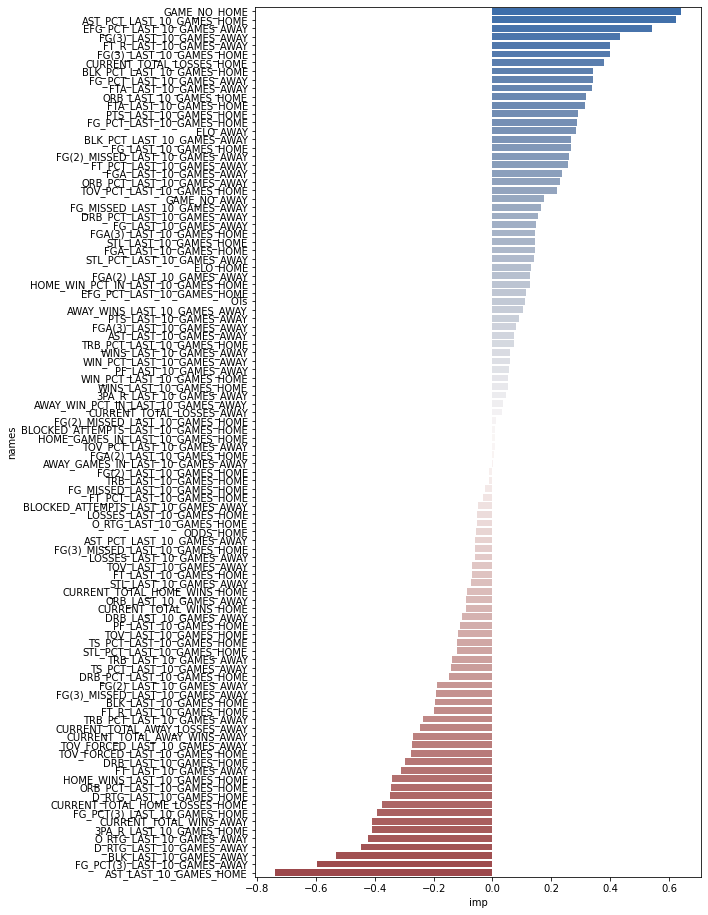

In [205]:
a4_dims = (8,16)
fig, ax = plt.subplots(figsize=a4_dims)
df_imp=pd.DataFrame.from_dict(varimp)
df_imp.sort_values(ascending=False,by=["imp"],inplace=True)
sns.barplot(x="imp",y="names",palette="vlag",data=df_imp,orient="h",ax=ax);

The features that are important to the linear regression model make sense but the most positiviely important column being the game number for the home team doesn't make that much sense. I guess you can tie it to attrition or the fact that certain teams tend to perform better later on in the season as numerous teams tank in preparation for the offseason and as others try and get into rhythm prior to the playoffs but that's just a hypothesis.

It feels as if there's just too much noise in this dataset, I believe I will have to customize my own X variables or use PCA to determine which features to use. I will have to eventually customize hyper-parameters but a model and feature-set has to make themselves more distinct prior to me undergoing the task of performing random searches and technically intensive grid searches.

#### FEATURE-SET 1

Using features based on variance

Other ML NBA models that have large datasets have the luxury to use less features due to the magnitude of their data but due to the constraints of trying to predict based off the training dataset of one half of a season, it's likely best if I use more features even if it causes more variance.

In [206]:
features = numeric.drop(columns=['SEASON', 'HOME_WIN/LABEL']).var().sort_values(ascending=False).head(40).index

_2014_df = numeric.loc[numeric['SEASON'] == 2014]
X1 = _2014_df[features]
y1 = _2014_df['HOME_WIN/LABEL']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,random_state=42, shuffle=False, test_size=0.5)
_2015_df = numeric.loc[numeric['SEASON'] == 2015]
X2 = _2015_df[features]
y2 = _2015_df['HOME_WIN/LABEL']
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,random_state=42, shuffle=False, test_size=0.5)
_2016_df = numeric.loc[numeric['SEASON'] == 2016]
X3 = _2016_df[features]
y3 = _2016_df['HOME_WIN/LABEL']
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,random_state=42, shuffle=False, test_size=0.5)
_2017_df = numeric.loc[numeric['SEASON'] == 2017]
X4 = _2017_df[features]
y4 = _2017_df['HOME_WIN/LABEL']
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,random_state=42, shuffle=False, test_size=0.5)
_2018_df = numeric.loc[numeric['SEASON'] == 2018]
X5 = _2018_df[features]
y5 = _2018_df['HOME_WIN/LABEL']
X5_train,X5_test,y5_train,y5_test = train_test_split(X5,y5,random_state=42, shuffle=False, test_size=0.5)
_2019_df = numeric.loc[numeric['SEASON'] == 2019]
X6 = _2019_df[features]
y6 = _2019_df['HOME_WIN/LABEL']
X6_train,X6_test,y6_train,y6_test = train_test_split(X6,y6,random_state=42, shuffle=False, test_size=0.5)

In [207]:
X1.corr()

,ELO_HOME,ELO_AWAY,GAME_NO_HOME,GAME_NO_AWAY,CURRENT_TOTAL_LOSSES_HOME,CURRENT_TOTAL_WINS_AWAY,CURRENT_TOTAL_WINS_HOME,CURRENT_TOTAL_LOSSES_AWAY,PTS_LAST_10_GAMES_HOME,PTS_LAST_10_GAMES_AWAY,...,ORB_PCT_LAST_10_GAMES_AWAY,ORB_PCT_LAST_10_GAMES_HOME,FTA_LAST_10_GAMES_AWAY,FTA_LAST_10_GAMES_HOME,DRB_PCT_LAST_10_GAMES_AWAY,DRB_PCT_LAST_10_GAMES_HOME,FG_MISSED_LAST_10_GAMES_HOME,FG_MISSED_LAST_10_GAMES_AWAY,TRB_LAST_10_GAMES_HOME,TRB_LAST_10_GAMES_AWAY
ELO_HOME,1.000000,-0.005217,0.000341,-0.001065,-0.511961,0.001220,0.510708,0.002719,0.465990,0.051141,...,0.009982,-0.014826,0.043721,0.112198,-0.000979,0.153477,-0.407528,0.007393,0.178296,0.031134
ELO_AWAY,-0.005217,1.000000,-0.008397,-0.009446,0.001269,0.503405,-0.018276,-0.519580,0.046106,0.455568,...,-0.022928,0.032552,0.114859,0.009417,0.174305,-0.021175,-0.022405,-0.415018,0.029879,0.176286
GAME_NO_HOME,0.000341,-0.008397,1.000000,0.997960,0.840249,0.837745,0.841228,0.836199,0.171415,0.151473,...,-0.012677,-0.048875,0.012537,0.028916,0.042283,0.015970,-0.091351,-0.121678,-0.099002,-0.106549
GAME_NO_AWAY,-0.001065,-0.009446,0.997960,1.000000,0.838862,0.838619,0.838739,0.839017,0.168287,0.155753,...,-0.013941,-0.049758,0.013534,0.026685,0.046318,0.013225,-0.093226,-0.119290,-0.103748,-0.101869
CURRENT_TOTAL_LOSSES_HOME,-0.511961,0.001269,0.840249,0.838862,1.000000,0.705207,0.417069,0.698916,-0.072578,0.103358,...,-0.011247,-0.017198,-0.012406,-0.026834,0.037246,-0.051990,0.107507,-0.104618,-0.177933,-0.103067
CURRENT_TOTAL_WINS_AWAY,0.001220,0.503405,0.837745,0.838619,0.705207,1.000000,0.701887,0.411752,0.165344,0.337901,...,-0.050184,-0.024639,0.060785,0.033717,0.107653,0.006310,-0.089734,-0.293369,-0.063998,-0.002949
CURRENT_TOTAL_WINS_HOME,0.510708,-0.018276,0.841228,0.838739,0.417069,0.701887,1.000000,0.708028,0.356073,0.148914,...,-0.008491,-0.063428,0.031066,0.070086,0.032782,0.079345,-0.257238,-0.099528,0.008276,-0.077827
CURRENT_TOTAL_LOSSES_AWAY,0.002719,-0.519580,0.836199,0.839017,0.698916,0.411752,0.708028,1.000000,0.122123,-0.076945,...,0.027414,-0.056535,-0.039707,0.017274,-0.030933,0.017798,-0.068359,0.095738,-0.105431,-0.168153
PTS_LAST_10_GAMES_HOME,0.465990,0.046106,0.171415,0.168287,-0.072578,0.165344,0.356073,0.122123,1.000000,0.080936,...,0.008061,0.084228,-0.001495,0.364422,0.068310,-0.065186,-0.206838,-0.021608,0.226357,0.035218
PTS_LAST_10_GAMES_AWAY,0.051141,0.455568,0.151473,0.155753,0.103358,0.337901,0.148914,-0.076945,0.080936,1.000000,...,0.056277,0.023667,0.364299,0.047746,-0.012386,0.022690,-0.030850,-0.217325,0.040872,0.226569


In [208]:
mlr_lst = []
dt_lst = []
knn_lst = []
bag_lst = []
rf_lst = []
ada_lst = []
gboost_lst = []

In [209]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X1_train,y1_train)
pipe_knn.fit(X1_train,y1_train)
pipe_dtree.fit(X1_train,y1_train)
pipe_bag.fit(X1_train,y1_train)
pipe_rf.fit(X1_train,y1_train)
pipe_ada.fit(X1_train,y1_train)
pipe_gboost.fit(X1_train,y1_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X1_train,y1_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X1_test,y1_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X1_train,y1_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X1_test,y1_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X1_train,y1_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X1_test,y1_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X1_train,y1_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X1_test,y1_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X1_train,y1_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X1_test,y1_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X1_train,y1_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X1_test,y1_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X1_train,y1_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X1_test,y1_test)}')

mlr_lst.append(pipe_mlr.score(X1_test,y1_test))
knn_lst.append(pipe_knn.score(X1_test,y1_test))
dt_lst.append(pipe_dtree.score(X1_test,y1_test))
bag_lst.append(pipe_bag.score(X1_test,y1_test))
rf_lst.append(pipe_rf.score(X1_test,y1_test))
ada_lst.append(pipe_ada.score(X1_test,y1_test))
gboost_lst.append(pipe_gboost.score(X1_test,y1_test))

Multiple Logistic Regression Train Score is: 0.6010016694490818
Multiple Logistic Regression Test Score is: 0.5266666666666666
K Nearest Neighbors Classifier Train Score is: 0.6928213689482471
K Nearest Neighbors Classifier Test Score is: 0.49166666666666664
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.48833333333333334
Bagging Classifier Train Score is: 0.9766277128547579
Bagging Classifier Test Score is: 0.5033333333333333
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.49833333333333335
Gradient Boost Train Score is: 0.9682804674457429
Gradient Boost Test Score is: 0.4816666666666667


In [210]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X2_train,y2_train)
pipe_knn.fit(X2_train,y2_train)
pipe_dtree.fit(X2_train,y2_train)
pipe_bag.fit(X2_train,y2_train)
pipe_rf.fit(X2_train,y2_train)
pipe_ada.fit(X2_train,y2_train)
pipe_gboost.fit(X2_train,y2_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X2_train,y2_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X2_test,y2_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X2_train,y2_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X2_test,y2_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X2_train,y2_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X2_test,y2_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X2_train,y2_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X2_test,y2_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X2_train,y2_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X2_test,y2_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X2_train,y2_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X2_test,y2_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X2_train,y2_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X2_test,y2_test)}')

mlr_lst.append(pipe_mlr.score(X2_test,y2_test))
knn_lst.append(pipe_knn.score(X2_test,y2_test))
dt_lst.append(pipe_dtree.score(X2_test,y2_test))
bag_lst.append(pipe_bag.score(X2_test,y2_test))
rf_lst.append(pipe_rf.score(X2_test,y2_test))
ada_lst.append(pipe_ada.score(X2_test,y2_test))
gboost_lst.append(pipe_gboost.score(X2_test,y2_test))

Multiple Logistic Regression Train Score is: 0.5916666666666667
Multiple Logistic Regression Test Score is: 0.51
K Nearest Neighbors Classifier Train Score is: 0.71
K Nearest Neighbors Classifier Test Score is: 0.525
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5033333333333333
Bagging Classifier Train Score is: 0.9883333333333333
Bagging Classifier Test Score is: 0.5066666666666667
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5016666666666667
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.495
Gradient Boost Train Score is: 0.9683333333333334
Gradient Boost Test Score is: 0.4816666666666667


In [211]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X3_train,y3_train)
pipe_knn.fit(X3_train,y3_train)
pipe_dtree.fit(X3_train,y3_train)
pipe_bag.fit(X3_train,y3_train)
pipe_rf.fit(X3_train,y3_train)
pipe_ada.fit(X3_train,y3_train)
pipe_gboost.fit(X3_train,y3_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X3_train,y3_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X3_test,y3_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X3_train,y3_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X3_test,y3_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X3_train,y3_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X3_test,y3_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X3_train,y3_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X3_test,y3_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X3_train,y3_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X3_test,y3_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X3_train,y3_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X3_test,y3_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X3_train,y3_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X3_test,y3_test)}')

mlr_lst.append(pipe_mlr.score(X3_test,y3_test))
knn_lst.append(pipe_knn.score(X3_test,y3_test))
dt_lst.append(pipe_dtree.score(X3_test,y3_test))
bag_lst.append(pipe_bag.score(X3_test,y3_test))
rf_lst.append(pipe_rf.score(X3_test,y3_test))
ada_lst.append(pipe_ada.score(X3_test,y3_test))
gboost_lst.append(pipe_gboost.score(X3_test,y3_test))

Multiple Logistic Regression Train Score is: 0.6204013377926422
Multiple Logistic Regression Test Score is: 0.540133779264214
K Nearest Neighbors Classifier Train Score is: 0.6839464882943144
K Nearest Neighbors Classifier Test Score is: 0.5551839464882943
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.48327759197324416
Bagging Classifier Train Score is: 0.9832775919732442
Bagging Classifier Test Score is: 0.5117056856187291
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5033444816053512
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.46321070234113715
Gradient Boost Train Score is: 0.9682274247491639
Gradient Boost Test Score is: 0.5066889632107023


In [212]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X4_train,y4_train)
pipe_knn.fit(X4_train,y4_train)
pipe_dtree.fit(X4_train,y4_train)
pipe_bag.fit(X4_train,y4_train)
pipe_rf.fit(X4_train,y4_train)
pipe_ada.fit(X4_train,y4_train)
pipe_gboost.fit(X4_train,y4_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X4_train,y4_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X4_test,y4_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X4_train,y4_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X4_test,y4_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X4_train,y4_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X4_test,y4_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X4_train,y4_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X4_test,y4_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X4_train,y4_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X4_test,y4_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X4_train,y4_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X4_test,y4_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X4_train,y4_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X4_test,y4_test)}')

mlr_lst.append(pipe_mlr.score(X4_test,y4_test))
knn_lst.append(pipe_knn.score(X4_test,y4_test))
dt_lst.append(pipe_dtree.score(X4_test,y4_test))
bag_lst.append(pipe_bag.score(X4_test,y4_test))
rf_lst.append(pipe_rf.score(X4_test,y4_test))
ada_lst.append(pipe_ada.score(X4_test,y4_test))
gboost_lst.append(pipe_gboost.score(X4_test,y4_test))

Multiple Logistic Regression Train Score is: 0.617056856187291
Multiple Logistic Regression Test Score is: 0.5058430717863105
K Nearest Neighbors Classifier Train Score is: 0.697324414715719
K Nearest Neighbors Classifier Test Score is: 0.4974958263772955
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5091819699499165
Bagging Classifier Train Score is: 0.9899665551839465
Bagging Classifier Test Score is: 0.5075125208681135
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.4941569282136895
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5375626043405676
Gradient Boost Train Score is: 0.9749163879598662
Gradient Boost Test Score is: 0.5292153589315526


In [213]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X5_train,y5_train)
pipe_knn.fit(X5_train,y5_train)
pipe_dtree.fit(X5_train,y5_train)
pipe_bag.fit(X5_train,y5_train)
pipe_rf.fit(X5_train,y5_train)
pipe_ada.fit(X5_train,y5_train)
pipe_gboost.fit(X5_train,y5_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X5_train,y5_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X5_test,y5_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X5_train,y5_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X5_test,y5_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X5_train,y5_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X5_test,y5_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X5_train,y5_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X5_test,y5_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X5_train,y5_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X5_test,y5_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X5_train,y5_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X5_test,y5_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X5_train,y5_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X5_test,y5_test)}')

mlr_lst.append(pipe_mlr.score(X5_test,y5_test))
knn_lst.append(pipe_knn.score(X5_test,y5_test))
dt_lst.append(pipe_dtree.score(X5_test,y5_test))
bag_lst.append(pipe_bag.score(X5_test,y5_test))
rf_lst.append(pipe_rf.score(X5_test,y5_test))
ada_lst.append(pipe_ada.score(X5_test,y5_test))
gboost_lst.append(pipe_gboost.score(X5_test,y5_test))

Multiple Logistic Regression Train Score is: 0.5795644891122278
Multiple Logistic Regression Test Score is: 0.48327759197324416
K Nearest Neighbors Classifier Train Score is: 0.7169179229480737
K Nearest Neighbors Classifier Test Score is: 0.4983277591973244
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5050167224080268
Bagging Classifier Train Score is: 0.9899497487437185
Bagging Classifier Test Score is: 0.5016722408026756
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5183946488294314
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5083612040133779
Gradient Boost Train Score is: 0.9530988274706867
Gradient Boost Test Score is: 0.4916387959866221


In [214]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X6_train,y6_train)
pipe_knn.fit(X6_train,y6_train)
pipe_dtree.fit(X6_train,y6_train)
pipe_bag.fit(X6_train,y6_train)
pipe_rf.fit(X6_train,y6_train)
pipe_ada.fit(X6_train,y6_train)
pipe_gboost.fit(X6_train,y6_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X6_train,y6_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X6_test,y6_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X6_train,y6_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X6_test,y6_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X6_train,y6_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X6_test,y6_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X6_train,y6_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X6_test,y6_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X6_train,y6_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X6_test,y6_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X6_train,y6_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X6_test,y6_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X6_train,y6_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X6_test,y6_test)}')

mlr_lst.append(pipe_mlr.score(X6_test,y6_test))
knn_lst.append(pipe_knn.score(X6_test,y6_test))
dt_lst.append(pipe_dtree.score(X6_test,y6_test))
bag_lst.append(pipe_bag.score(X6_test,y6_test))
rf_lst.append(pipe_rf.score(X6_test,y6_test))
ada_lst.append(pipe_ada.score(X6_test,y6_test))
gboost_lst.append(pipe_gboost.score(X6_test,y6_test))

Multiple Logistic Regression Train Score is: 0.5826377295492488
Multiple Logistic Regression Test Score is: 0.5
K Nearest Neighbors Classifier Train Score is: 0.671118530884808
K Nearest Neighbors Classifier Test Score is: 0.49833333333333335
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5133333333333333
Bagging Classifier Train Score is: 0.986644407345576
Bagging Classifier Test Score is: 0.47833333333333333
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5033333333333333
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5083333333333333
Gradient Boost Train Score is: 0.9632721202003339
Gradient Boost Test Score is: 0.5216666666666666


In [215]:
import statistics as stats

In [216]:
print(f'The logistic regression score: {stats.mean(mlr_lst)}')
print(f'The K nearest neighbors classifier score: {stats.mean(knn_lst)}')
print(f'The decision tree classifier score: {stats.mean(dt_lst)}')
print(f'The bagging classifier score: {stats.mean(bag_lst)}')
print(f'The random forest classifier score: {stats.mean(rf_lst)}')
print(f'The ada boost classifier score: {stats.mean(ada_lst)}')
print(f'The gradient boost classifier score: {stats.mean(gboost_lst)}')

The logistic regression score: 0.5109868516150725
The K nearest neighbors classifier score: 0.511001255343819
The decision tree classifier score: 0.5004127140551979
The bagging classifier score: 0.5015372967704752
The random forest classifier score: 0.503482676441412
The ada boost classifier score: 0.5018001962269583
The gradient boost classifier score: 0.5020905196881462


#### FEATURE SET (PCA)

Utilizing PCA, to select which features are the best combination of which to extract

In [217]:
from sklearn.decomposition import PCA

In [218]:
pca = PCA()

In [219]:
features = numeric.drop(columns=['SEASON', 'HOME_WIN/LABEL'])
X_train,X_test = train_test_split(features, random_state=42, shuffle=False, test_size=0.5)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
Z_train = pca.fit_transform(X_train)

In [220]:
var_exp = pca.explained_variance_ratio_
var_exp[:20]

array([0.10396104, 0.08818831, 0.07650899, 0.05184407, 0.05042465,
       0.04609432, 0.04308137, 0.03968456, 0.03836943, 0.03699863,
       0.03577576, 0.03244611, 0.03216531, 0.02709238, 0.02566251,
       0.01938912, 0.01921179, 0.01740914, 0.01618494, 0.01584789])

In [221]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
cum_var_exp[20]

0.8311393452378003

In [222]:
cum_var_exp[30], cum_var_exp[35], cum_var_exp[40], cum_var_exp[45]

(0.9326732040118061, 0.965387489751576, 0.9858107025086362, 0.9949913008736406)

I am going to be using PCA components 30, 35, and 40 for these upcoming cells, seeing which hold better improvements

### PCA 35

In [223]:
pca_35 = PCA(n_components=35)

In [224]:
_2014_df = numeric.loc[numeric['SEASON'] == 2014]
X1 = _2014_df[features.columns]
y1 = _2014_df['HOME_WIN/LABEL']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,random_state=42, shuffle=False, test_size=0.5)
_2015_df = numeric.loc[numeric['SEASON'] == 2015]
X2 = _2015_df[features.columns]
y2 = _2015_df['HOME_WIN/LABEL']
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,random_state=42, shuffle=False, test_size=0.5)
_2016_df = numeric.loc[numeric['SEASON'] == 2016]
X3 = _2016_df[features.columns]
y3 = _2016_df['HOME_WIN/LABEL']
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,random_state=42, shuffle=False, test_size=0.5)
_2017_df = numeric.loc[numeric['SEASON'] == 2017]
X4 = _2017_df[features.columns]
y4 = _2017_df['HOME_WIN/LABEL']
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,random_state=42, shuffle=False, test_size=0.5)
_2018_df = numeric.loc[numeric['SEASON'] == 2018]
X5 = _2018_df[features.columns]
y5 = _2018_df['HOME_WIN/LABEL']
X5_train,X5_test,y5_train,y5_test = train_test_split(X5,y5,random_state=42, shuffle=False, test_size=0.5)
_2019_df = numeric.loc[numeric['SEASON'] == 2019]
X6 = _2019_df[features.columns]
y6 = _2019_df['HOME_WIN/LABEL']
X6_train,X6_test,y6_train,y6_test = train_test_split(X6,y6,random_state=42, shuffle=False, test_size=0.5)

In [225]:
mlr_lst = []
dt_lst = []
knn_lst = []
bag_lst = []
rf_lst = []
ada_lst = []
gboost_lst = []

In [226]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X1_train,y1_train)
pipe_knn.fit(X1_train,y1_train)
pipe_dtree.fit(X1_train,y1_train)
pipe_bag.fit(X1_train,y1_train)
pipe_rf.fit(X1_train,y1_train)
pipe_ada.fit(X1_train,y1_train)
pipe_gboost.fit(X1_train,y1_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X1_train,y1_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X1_test,y1_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X1_train,y1_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X1_test,y1_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X1_train,y1_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X1_test,y1_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X1_train,y1_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X1_test,y1_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X1_train,y1_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X1_test,y1_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X1_train,y1_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X1_test,y1_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X1_train,y1_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X1_test,y1_test)}')

mlr_lst.append(pipe_mlr.score(X1_test,y1_test))
knn_lst.append(pipe_knn.score(X1_test,y1_test))
dt_lst.append(pipe_dtree.score(X1_test,y1_test))
bag_lst.append(pipe_bag.score(X1_test,y1_test))
rf_lst.append(pipe_rf.score(X1_test,y1_test))
ada_lst.append(pipe_ada.score(X1_test,y1_test))
gboost_lst.append(pipe_gboost.score(X1_test,y1_test))

Multiple Logistic Regression Train Score is: 0.6243739565943238
Multiple Logistic Regression Test Score is: 0.535
K Nearest Neighbors Classifier Train Score is: 0.7045075125208681
K Nearest Neighbors Classifier Test Score is: 0.47333333333333333
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.4583333333333333
Bagging Classifier Train Score is: 0.989983305509182
Bagging Classifier Test Score is: 0.5233333333333333
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5033333333333333
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.4716666666666667
Gradient Boost Train Score is: 0.9732888146911519
Gradient Boost Test Score is: 0.465


In [227]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X2_train,y2_train)
pipe_knn.fit(X2_train,y2_train)
pipe_dtree.fit(X2_train,y2_train)
pipe_bag.fit(X2_train,y2_train)
pipe_rf.fit(X2_train,y2_train)
pipe_ada.fit(X2_train,y2_train)
pipe_gboost.fit(X2_train,y2_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X2_train,y2_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X2_test,y2_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X2_train,y2_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X2_test,y2_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X2_train,y2_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X2_test,y2_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X2_train,y2_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X2_test,y2_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X2_train,y2_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X2_test,y2_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X2_train,y2_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X2_test,y2_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X2_train,y2_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X2_test,y2_test)}')

mlr_lst.append(pipe_mlr.score(X2_test,y2_test))
knn_lst.append(pipe_knn.score(X2_test,y2_test))
dt_lst.append(pipe_dtree.score(X2_test,y2_test))
bag_lst.append(pipe_bag.score(X2_test,y2_test))
rf_lst.append(pipe_rf.score(X2_test,y2_test))
ada_lst.append(pipe_ada.score(X2_test,y2_test))
gboost_lst.append(pipe_gboost.score(X2_test,y2_test))

Multiple Logistic Regression Train Score is: 0.6
Multiple Logistic Regression Test Score is: 0.5
K Nearest Neighbors Classifier Train Score is: 0.69
K Nearest Neighbors Classifier Test Score is: 0.5166666666666667
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.535
Bagging Classifier Train Score is: 0.9833333333333333
Bagging Classifier Test Score is: 0.505
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.46166666666666667
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5233333333333333
Gradient Boost Train Score is: 0.985
Gradient Boost Test Score is: 0.48833333333333334


In [228]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X3_train,y3_train)
pipe_knn.fit(X3_train,y3_train)
pipe_dtree.fit(X3_train,y3_train)
pipe_bag.fit(X3_train,y3_train)
pipe_rf.fit(X3_train,y3_train)
pipe_ada.fit(X3_train,y3_train)
pipe_gboost.fit(X3_train,y3_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X3_train,y3_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X3_test,y3_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X3_train,y3_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X3_test,y3_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X3_train,y3_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X3_test,y3_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X3_train,y3_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X3_test,y3_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X3_train,y3_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X3_test,y3_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X3_train,y3_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X3_test,y3_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X3_train,y3_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X3_test,y3_test)}')

mlr_lst.append(pipe_mlr.score(X3_test,y3_test))
knn_lst.append(pipe_knn.score(X3_test,y3_test))
dt_lst.append(pipe_dtree.score(X3_test,y3_test))
bag_lst.append(pipe_bag.score(X3_test,y3_test))
rf_lst.append(pipe_rf.score(X3_test,y3_test))
ada_lst.append(pipe_ada.score(X3_test,y3_test))
gboost_lst.append(pipe_gboost.score(X3_test,y3_test))

Multiple Logistic Regression Train Score is: 0.6237458193979933
Multiple Logistic Regression Test Score is: 0.5234113712374582
K Nearest Neighbors Classifier Train Score is: 0.6956521739130435
K Nearest Neighbors Classifier Test Score is: 0.5083612040133779
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.4816053511705686
Bagging Classifier Train Score is: 0.9882943143812709
Bagging Classifier Test Score is: 0.49331103678929766
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5016722408026756
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.47491638795986624
Gradient Boost Train Score is: 0.9816053511705686
Gradient Boost Test Score is: 0.49331103678929766


In [229]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X4_train,y4_train)
pipe_knn.fit(X4_train,y4_train)
pipe_dtree.fit(X4_train,y4_train)
pipe_bag.fit(X4_train,y4_train)
pipe_rf.fit(X4_train,y4_train)
pipe_ada.fit(X4_train,y4_train)
pipe_gboost.fit(X4_train,y4_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X4_train,y4_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X4_test,y4_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X4_train,y4_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X4_test,y4_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X4_train,y4_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X4_test,y4_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X4_train,y4_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X4_test,y4_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X4_train,y4_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X4_test,y4_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X4_train,y4_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X4_test,y4_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X4_train,y4_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X4_test,y4_test)}')

mlr_lst.append(pipe_mlr.score(X4_test,y4_test))
knn_lst.append(pipe_knn.score(X4_test,y4_test))
dt_lst.append(pipe_dtree.score(X4_test,y4_test))
bag_lst.append(pipe_bag.score(X4_test,y4_test))
rf_lst.append(pipe_rf.score(X4_test,y4_test))
ada_lst.append(pipe_ada.score(X4_test,y4_test))
gboost_lst.append(pipe_gboost.score(X4_test,y4_test))

Multiple Logistic Regression Train Score is: 0.6120401337792643
Multiple Logistic Regression Test Score is: 0.48580968280467446
K Nearest Neighbors Classifier Train Score is: 0.677257525083612
K Nearest Neighbors Classifier Test Score is: 0.49081803005008345
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5308848080133556
Bagging Classifier Train Score is: 0.9849498327759197
Bagging Classifier Test Score is: 0.48747913188647746
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5008347245409015
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5075125208681135
Gradient Boost Train Score is: 0.9882943143812709
Gradient Boost Test Score is: 0.48580968280467446


In [230]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X5_train,y5_train)
pipe_knn.fit(X5_train,y5_train)
pipe_dtree.fit(X5_train,y5_train)
pipe_bag.fit(X5_train,y5_train)
pipe_rf.fit(X5_train,y5_train)
pipe_ada.fit(X5_train,y5_train)
pipe_gboost.fit(X5_train,y5_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X5_train,y5_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X5_test,y5_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X5_train,y5_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X5_test,y5_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X5_train,y5_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X5_test,y5_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X5_train,y5_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X5_test,y5_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X5_train,y5_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X5_test,y5_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X5_train,y5_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X5_test,y5_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X5_train,y5_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X5_test,y5_test)}')

mlr_lst.append(pipe_mlr.score(X5_test,y5_test))
knn_lst.append(pipe_knn.score(X5_test,y5_test))
dt_lst.append(pipe_dtree.score(X5_test,y5_test))
bag_lst.append(pipe_bag.score(X5_test,y5_test))
rf_lst.append(pipe_rf.score(X5_test,y5_test))
ada_lst.append(pipe_ada.score(X5_test,y5_test))
gboost_lst.append(pipe_gboost.score(X5_test,y5_test))

Multiple Logistic Regression Train Score is: 0.5963149078726968
Multiple Logistic Regression Test Score is: 0.5100334448160535
K Nearest Neighbors Classifier Train Score is: 0.7169179229480737
K Nearest Neighbors Classifier Test Score is: 0.5183946488294314
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5150501672240803
Bagging Classifier Train Score is: 0.9765494137353434
Bagging Classifier Test Score is: 0.4765886287625418
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5167224080267558
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.4916387959866221
Gradient Boost Train Score is: 0.9798994974874372
Gradient Boost Test Score is: 0.47324414715719065


In [231]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=35)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X6_train,y6_train)
pipe_knn.fit(X6_train,y6_train)
pipe_dtree.fit(X6_train,y6_train)
pipe_bag.fit(X6_train,y6_train)
pipe_rf.fit(X6_train,y6_train)
pipe_ada.fit(X6_train,y6_train)
pipe_gboost.fit(X6_train,y6_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X6_train,y6_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X6_test,y6_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X6_train,y6_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X6_test,y6_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X6_train,y6_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X6_test,y6_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X6_train,y6_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X6_test,y6_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X6_train,y6_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X6_test,y6_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X6_train,y6_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X6_test,y6_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X6_train,y6_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X6_test,y6_test)}')

mlr_lst.append(pipe_mlr.score(X6_test,y6_test))
knn_lst.append(pipe_knn.score(X6_test,y6_test))
dt_lst.append(pipe_dtree.score(X6_test,y6_test))
bag_lst.append(pipe_bag.score(X6_test,y6_test))
rf_lst.append(pipe_rf.score(X6_test,y6_test))
ada_lst.append(pipe_ada.score(X6_test,y6_test))
gboost_lst.append(pipe_gboost.score(X6_test,y6_test))

Multiple Logistic Regression Train Score is: 0.6060100166944908
Multiple Logistic Regression Test Score is: 0.5283333333333333
K Nearest Neighbors Classifier Train Score is: 0.6978297161936561
K Nearest Neighbors Classifier Test Score is: 0.525
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5316666666666666
Bagging Classifier Train Score is: 0.9849749582637729
Bagging Classifier Test Score is: 0.5383333333333333
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.53
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5316666666666666
Gradient Boost Train Score is: 0.991652754590985
Gradient Boost Test Score is: 0.5566666666666666


In [232]:
print(f'The logistic regression score: {stats.mean(mlr_lst)}')
print(f'The K nearest neighbors classifier score: {stats.mean(knn_lst)}')
print(f'The decision tree classifier score: {stats.mean(dt_lst)}')
print(f'The bagging classifier score: {stats.mean(bag_lst)}')
print(f'The random forest classifier score: {stats.mean(rf_lst)}')
print(f'The ada boost classifier score: {stats.mean(ada_lst)}')
print(f'The gradient boost classifier score: {stats.mean(gboost_lst)}')

The logistic regression score: 0.5137646386985866
The K nearest neighbors classifier score: 0.5054289804821488
The decision tree classifier score: 0.5087567210680007
The bagging classifier score: 0.5040075773508306
The random forest classifier score: 0.5023715622283889
The ada boost classifier score: 0.5001223952468781
The gradient boost classifier score: 0.49372747779186044


### PCA 30

In [233]:
pca_30 = PCA(n_components=30)

In [234]:
_2014_df = numeric.loc[numeric['SEASON'] == 2014]
X1 = _2014_df[features.columns]
y1 = _2014_df['HOME_WIN/LABEL']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,random_state=42, shuffle=False, test_size=0.5)
_2015_df = numeric.loc[numeric['SEASON'] == 2015]
X2 = _2015_df[features.columns]
y2 = _2015_df['HOME_WIN/LABEL']
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,random_state=42, shuffle=False, test_size=0.5)
_2016_df = numeric.loc[numeric['SEASON'] == 2016]
X3 = _2016_df[features.columns]
y3 = _2016_df['HOME_WIN/LABEL']
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,random_state=42, shuffle=False, test_size=0.5)
_2017_df = numeric.loc[numeric['SEASON'] == 2017]
X4 = _2017_df[features.columns]
y4 = _2017_df['HOME_WIN/LABEL']
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,random_state=42, shuffle=False, test_size=0.5)
_2018_df = numeric.loc[numeric['SEASON'] == 2018]
X5 = _2018_df[features.columns]
y5 = _2018_df['HOME_WIN/LABEL']
X5_train,X5_test,y5_train,y5_test = train_test_split(X5,y5,random_state=42, shuffle=False, test_size=0.5)
_2019_df = numeric.loc[numeric['SEASON'] == 2019]
X6 = _2019_df[features.columns]
y6 = _2019_df['HOME_WIN/LABEL']
X6_train,X6_test,y6_train,y6_test = train_test_split(X6,y6,random_state=42, shuffle=False, test_size=0.5)

In [235]:
mlr_lst = []
dt_lst = []
knn_lst = []
bag_lst = []
rf_lst = []
ada_lst = []
gboost_lst = []

In [236]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca35', PCA(n_components=30)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X1_train,y1_train)
pipe_knn.fit(X1_train,y1_train)
pipe_dtree.fit(X1_train,y1_train)
pipe_bag.fit(X1_train,y1_train)
pipe_rf.fit(X1_train,y1_train)
pipe_ada.fit(X1_train,y1_train)
pipe_gboost.fit(X1_train,y1_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X1_train,y1_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X1_test,y1_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X1_train,y1_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X1_test,y1_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X1_train,y1_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X1_test,y1_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X1_train,y1_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X1_test,y1_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X1_train,y1_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X1_test,y1_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X1_train,y1_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X1_test,y1_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X1_train,y1_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X1_test,y1_test)}')

mlr_lst.append(pipe_mlr.score(X1_test,y1_test))
knn_lst.append(pipe_knn.score(X1_test,y1_test))
dt_lst.append(pipe_dtree.score(X1_test,y1_test))
bag_lst.append(pipe_bag.score(X1_test,y1_test))
rf_lst.append(pipe_rf.score(X1_test,y1_test))
ada_lst.append(pipe_ada.score(X1_test,y1_test))
gboost_lst.append(pipe_gboost.score(X1_test,y1_test))

Multiple Logistic Regression Train Score is: 0.6026711185308848
Multiple Logistic Regression Test Score is: 0.5183333333333333
K Nearest Neighbors Classifier Train Score is: 0.7128547579298832
K Nearest Neighbors Classifier Test Score is: 0.49333333333333335
Decision Tree Classifier Train Score is: 0.989983305509182
Decision Tree Classifier Test Score is: 0.4866666666666667
Bagging Classifier Train Score is: 0.9782971619365609
Bagging Classifier Test Score is: 0.5166666666666667
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.495
Ada Boost Classifier Train Score is: 0.998330550918197
Ada Boost Classifier Test Score is: 0.49
Gradient Boost Train Score is: 0.9649415692821369
Gradient Boost Test Score is: 0.4816666666666667


In [237]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X2_train,y2_train)
pipe_knn.fit(X2_train,y2_train)
pipe_dtree.fit(X2_train,y2_train)
pipe_bag.fit(X2_train,y2_train)
pipe_rf.fit(X2_train,y2_train)
pipe_ada.fit(X2_train,y2_train)
pipe_gboost.fit(X2_train,y2_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X2_train,y2_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X2_test,y2_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X2_train,y2_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X2_test,y2_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X2_train,y2_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X2_test,y2_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X2_train,y2_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X2_test,y2_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X2_train,y2_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X2_test,y2_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X2_train,y2_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X2_test,y2_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X2_train,y2_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X2_test,y2_test)}')

mlr_lst.append(pipe_mlr.score(X2_test,y2_test))
knn_lst.append(pipe_knn.score(X2_test,y2_test))
dt_lst.append(pipe_dtree.score(X2_test,y2_test))
bag_lst.append(pipe_bag.score(X2_test,y2_test))
rf_lst.append(pipe_rf.score(X2_test,y2_test))
ada_lst.append(pipe_ada.score(X2_test,y2_test))
gboost_lst.append(pipe_gboost.score(X2_test,y2_test))

Multiple Logistic Regression Train Score is: 0.585
Multiple Logistic Regression Test Score is: 0.495
K Nearest Neighbors Classifier Train Score is: 0.6866666666666666
K Nearest Neighbors Classifier Test Score is: 0.5066666666666667
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.48833333333333334
Bagging Classifier Train Score is: 0.9766666666666667
Bagging Classifier Test Score is: 0.5
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.515
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.48333333333333334
Gradient Boost Train Score is: 0.9766666666666667
Gradient Boost Test Score is: 0.48333333333333334


In [238]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X3_train,y3_train)
pipe_knn.fit(X3_train,y3_train)
pipe_dtree.fit(X3_train,y3_train)
pipe_bag.fit(X3_train,y3_train)
pipe_rf.fit(X3_train,y3_train)
pipe_ada.fit(X3_train,y3_train)
pipe_gboost.fit(X3_train,y3_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X3_train,y3_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X3_test,y3_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X3_train,y3_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X3_test,y3_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X3_train,y3_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X3_test,y3_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X3_train,y3_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X3_test,y3_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X3_train,y3_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X3_test,y3_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X3_train,y3_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X3_test,y3_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X3_train,y3_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X3_test,y3_test)}')

mlr_lst.append(pipe_mlr.score(X3_test,y3_test))
knn_lst.append(pipe_knn.score(X3_test,y3_test))
dt_lst.append(pipe_dtree.score(X3_test,y3_test))
bag_lst.append(pipe_bag.score(X3_test,y3_test))
rf_lst.append(pipe_rf.score(X3_test,y3_test))
ada_lst.append(pipe_ada.score(X3_test,y3_test))
gboost_lst.append(pipe_gboost.score(X3_test,y3_test))

Multiple Logistic Regression Train Score is: 0.6103678929765887
Multiple Logistic Regression Test Score is: 0.5033444816053512
K Nearest Neighbors Classifier Train Score is: 0.6739130434782609
K Nearest Neighbors Classifier Test Score is: 0.5050167224080268
Decision Tree Classifier Train Score is: 0.9983277591973244
Decision Tree Classifier Test Score is: 0.5384615384615384
Bagging Classifier Train Score is: 0.9882943143812709
Bagging Classifier Test Score is: 0.47157190635451507
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.48494983277591974
Ada Boost Classifier Train Score is: 0.9966555183946488
Ada Boost Classifier Test Score is: 0.5117056856187291
Gradient Boost Train Score is: 0.9816053511705686
Gradient Boost Test Score is: 0.4983277591973244


In [239]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X4_train,y4_train)
pipe_knn.fit(X4_train,y4_train)
pipe_dtree.fit(X4_train,y4_train)
pipe_bag.fit(X4_train,y4_train)
pipe_rf.fit(X4_train,y4_train)
pipe_ada.fit(X4_train,y4_train)
pipe_gboost.fit(X4_train,y4_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X4_train,y4_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X4_test,y4_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X4_train,y4_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X4_test,y4_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X4_train,y4_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X4_test,y4_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X4_train,y4_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X4_test,y4_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X4_train,y4_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X4_test,y4_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X4_train,y4_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X4_test,y4_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X4_train,y4_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X4_test,y4_test)}')

mlr_lst.append(pipe_mlr.score(X4_test,y4_test))
knn_lst.append(pipe_knn.score(X4_test,y4_test))
dt_lst.append(pipe_dtree.score(X4_test,y4_test))
bag_lst.append(pipe_bag.score(X4_test,y4_test))
rf_lst.append(pipe_rf.score(X4_test,y4_test))
ada_lst.append(pipe_ada.score(X4_test,y4_test))
gboost_lst.append(pipe_gboost.score(X4_test,y4_test))

Multiple Logistic Regression Train Score is: 0.5936454849498328
Multiple Logistic Regression Test Score is: 0.4958263772954925
K Nearest Neighbors Classifier Train Score is: 0.7107023411371237
K Nearest Neighbors Classifier Test Score is: 0.4974958263772955
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5242070116861436
Bagging Classifier Train Score is: 0.9849498327759197
Bagging Classifier Test Score is: 0.5041736227045075
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.48747913188647746
Ada Boost Classifier Train Score is: 0.9916387959866221
Ada Boost Classifier Test Score is: 0.5025041736227045
Gradient Boost Train Score is: 0.9882943143812709
Gradient Boost Test Score is: 0.5158597662771286


In [240]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X5_train,y5_train)
pipe_knn.fit(X5_train,y5_train)
pipe_dtree.fit(X5_train,y5_train)
pipe_bag.fit(X5_train,y5_train)
pipe_rf.fit(X5_train,y5_train)
pipe_ada.fit(X5_train,y5_train)
pipe_gboost.fit(X5_train,y5_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X5_train,y5_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X5_test,y5_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X5_train,y5_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X5_test,y5_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X5_train,y5_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X5_test,y5_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X5_train,y5_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X5_test,y5_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X5_train,y5_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X5_test,y5_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X5_train,y5_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X5_test,y5_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X5_train,y5_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X5_test,y5_test)}')

mlr_lst.append(pipe_mlr.score(X5_test,y5_test))
knn_lst.append(pipe_knn.score(X5_test,y5_test))
dt_lst.append(pipe_dtree.score(X5_test,y5_test))
bag_lst.append(pipe_bag.score(X5_test,y5_test))
rf_lst.append(pipe_rf.score(X5_test,y5_test))
ada_lst.append(pipe_ada.score(X5_test,y5_test))
gboost_lst.append(pipe_gboost.score(X5_test,y5_test))

Multiple Logistic Regression Train Score is: 0.5845896147403685
Multiple Logistic Regression Test Score is: 0.4916387959866221
K Nearest Neighbors Classifier Train Score is: 0.7001675041876047
K Nearest Neighbors Classifier Test Score is: 0.5234113712374582
Decision Tree Classifier Train Score is: 0.9966499162479062
Decision Tree Classifier Test Score is: 0.5
Bagging Classifier Train Score is: 0.9916247906197655
Bagging Classifier Test Score is: 0.46153846153846156
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.4916387959866221
Ada Boost Classifier Train Score is: 0.9916247906197655
Ada Boost Classifier Test Score is: 0.5033444816053512
Gradient Boost Train Score is: 0.9798994974874372
Gradient Boost Test Score is: 0.4866220735785953


In [241]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca30', PCA(n_components=30)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X6_train,y6_train)
pipe_knn.fit(X6_train,y6_train)
pipe_dtree.fit(X6_train,y6_train)
pipe_bag.fit(X6_train,y6_train)
pipe_rf.fit(X6_train,y6_train)
pipe_ada.fit(X6_train,y6_train)
pipe_gboost.fit(X6_train,y6_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X6_train,y6_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X6_test,y6_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X6_train,y6_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X6_test,y6_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X6_train,y6_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X6_test,y6_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X6_train,y6_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X6_test,y6_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X6_train,y6_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X6_test,y6_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X6_train,y6_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X6_test,y6_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X6_train,y6_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X6_test,y6_test)}')

mlr_lst.append(pipe_mlr.score(X6_test,y6_test))
knn_lst.append(pipe_knn.score(X6_test,y6_test))
dt_lst.append(pipe_dtree.score(X6_test,y6_test))
bag_lst.append(pipe_bag.score(X6_test,y6_test))
rf_lst.append(pipe_rf.score(X6_test,y6_test))
ada_lst.append(pipe_ada.score(X6_test,y6_test))
gboost_lst.append(pipe_gboost.score(X6_test,y6_test))

Multiple Logistic Regression Train Score is: 0.5959933222036727
Multiple Logistic Regression Test Score is: 0.5283333333333333
K Nearest Neighbors Classifier Train Score is: 0.6861435726210351
K Nearest Neighbors Classifier Test Score is: 0.5183333333333333
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.49833333333333335
Bagging Classifier Train Score is: 0.988313856427379
Bagging Classifier Test Score is: 0.495
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5566666666666666
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5016666666666667
Gradient Boost Train Score is: 0.9599332220367279
Gradient Boost Test Score is: 0.525


In [242]:
print(f'The logistic regression score: {stats.mean(mlr_lst)}')
print(f'The K nearest neighbors classifier score: {stats.mean(knn_lst)}')
print(f'The decision tree classifier score: {stats.mean(dt_lst)}')
print(f'The bagging classifier score: {stats.mean(bag_lst)}')
print(f'The random forest classifier score: {stats.mean(rf_lst)}')
print(f'The ada boost classifier score: {stats.mean(ada_lst)}')
print(f'The gradient boost classifier score: {stats.mean(gboost_lst)}')

The logistic regression score: 0.5054127202590221
The K nearest neighbors classifier score: 0.5073762088926856
The decision tree classifier score: 0.5060003139135025
The bagging classifier score: 0.4914917762106918
The random forest classifier score: 0.5051224045526144
The ada boost classifier score: 0.4987590568077975
The gradient boost classifier score: 0.4984682665088414


### PCA 40

In [243]:
pca_40 = PCA(n_components=40)

In [244]:
_2014_df = numeric.loc[numeric['SEASON'] == 2014]
X1 = _2014_df[features.columns]
y1 = _2014_df['HOME_WIN/LABEL']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,random_state=42, shuffle=False, test_size=0.5)
_2015_df = numeric.loc[numeric['SEASON'] == 2015]
X2 = _2015_df[features.columns]
y2 = _2015_df['HOME_WIN/LABEL']
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,random_state=42, shuffle=False, test_size=0.5)
_2016_df = numeric.loc[numeric['SEASON'] == 2016]
X3 = _2016_df[features.columns]
y3 = _2016_df['HOME_WIN/LABEL']
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,random_state=42, shuffle=False, test_size=0.5)
_2017_df = numeric.loc[numeric['SEASON'] == 2017]
X4 = _2017_df[features.columns]
y4 = _2017_df['HOME_WIN/LABEL']
X4_train,X4_test,y4_train,y4_test = train_test_split(X4,y4,random_state=42, shuffle=False, test_size=0.5)
_2018_df = numeric.loc[numeric['SEASON'] == 2018]
X5 = _2018_df[features.columns]
y5 = _2018_df['HOME_WIN/LABEL']
X5_train,X5_test,y5_train,y5_test = train_test_split(X5,y5,random_state=42, shuffle=False, test_size=0.5)
_2019_df = numeric.loc[numeric['SEASON'] == 2019]
X6 = _2019_df[features.columns]
y6 = _2019_df['HOME_WIN/LABEL']
X6_train,X6_test,y6_train,y6_test = train_test_split(X6,y6,random_state=42, shuffle=False, test_size=0.5)

In [245]:
mlr_lst = []
dt_lst = []
knn_lst = []
bag_lst = []
rf_lst = []
ada_lst = []
gboost_lst = []

In [246]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X1_train,y1_train)
pipe_knn.fit(X1_train,y1_train)
pipe_dtree.fit(X1_train,y1_train)
pipe_bag.fit(X1_train,y1_train)
pipe_rf.fit(X1_train,y1_train)
pipe_ada.fit(X1_train,y1_train)
pipe_gboost.fit(X1_train,y1_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X1_train,y1_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X1_test,y1_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X1_train,y1_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X1_test,y1_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X1_train,y1_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X1_test,y1_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X1_train,y1_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X1_test,y1_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X1_train,y1_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X1_test,y1_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X1_train,y1_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X1_test,y1_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X1_train,y1_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X1_test,y1_test)}')

mlr_lst.append(pipe_mlr.score(X1_test,y1_test))
knn_lst.append(pipe_knn.score(X1_test,y1_test))
dt_lst.append(pipe_dtree.score(X1_test,y1_test))
bag_lst.append(pipe_bag.score(X1_test,y1_test))
rf_lst.append(pipe_rf.score(X1_test,y1_test))
ada_lst.append(pipe_ada.score(X1_test,y1_test))
gboost_lst.append(pipe_gboost.score(X1_test,y1_test))

Multiple Logistic Regression Train Score is: 0.6227045075125208
Multiple Logistic Regression Test Score is: 0.5283333333333333
K Nearest Neighbors Classifier Train Score is: 0.6911519198664441
K Nearest Neighbors Classifier Test Score is: 0.475
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.4683333333333333
Bagging Classifier Train Score is: 0.986644407345576
Bagging Classifier Test Score is: 0.48333333333333334
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.47
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.4716666666666667
Gradient Boost Train Score is: 0.9732888146911519
Gradient Boost Test Score is: 0.43833333333333335


In [247]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X2_train,y2_train)
pipe_knn.fit(X2_train,y2_train)
pipe_dtree.fit(X2_train,y2_train)
pipe_bag.fit(X2_train,y2_train)
pipe_rf.fit(X2_train,y2_train)
pipe_ada.fit(X2_train,y2_train)
pipe_gboost.fit(X2_train,y2_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X2_train,y2_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X2_test,y2_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X2_train,y2_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X2_test,y2_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X2_train,y2_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X2_test,y2_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X2_train,y2_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X2_test,y2_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X2_train,y2_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X2_test,y2_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X2_train,y2_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X2_test,y2_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X2_train,y2_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X2_test,y2_test)}')

mlr_lst.append(pipe_mlr.score(X2_test,y2_test))
knn_lst.append(pipe_knn.score(X2_test,y2_test))
dt_lst.append(pipe_dtree.score(X2_test,y2_test))
bag_lst.append(pipe_bag.score(X2_test,y2_test))
rf_lst.append(pipe_rf.score(X2_test,y2_test))
ada_lst.append(pipe_ada.score(X2_test,y2_test))
gboost_lst.append(pipe_gboost.score(X2_test,y2_test))

Multiple Logistic Regression Train Score is: 0.605
Multiple Logistic Regression Test Score is: 0.49666666666666665
K Nearest Neighbors Classifier Train Score is: 0.6916666666666667
K Nearest Neighbors Classifier Test Score is: 0.5216666666666666
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5183333333333333
Bagging Classifier Train Score is: 0.9783333333333334
Bagging Classifier Test Score is: 0.5116666666666667
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.49333333333333335
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5133333333333333
Gradient Boost Train Score is: 0.9783333333333334
Gradient Boost Test Score is: 0.515


In [248]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X3_train,y3_train)
pipe_knn.fit(X3_train,y3_train)
pipe_dtree.fit(X3_train,y3_train)
pipe_bag.fit(X3_train,y3_train)
pipe_rf.fit(X3_train,y3_train)
pipe_ada.fit(X3_train,y3_train)
pipe_gboost.fit(X3_train,y3_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X3_train,y3_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X3_test,y3_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X3_train,y3_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X3_test,y3_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X3_train,y3_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X3_test,y3_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X3_train,y3_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X3_test,y3_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X3_train,y3_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X3_test,y3_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X3_train,y3_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X3_test,y3_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X3_train,y3_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X3_test,y3_test)}')

mlr_lst.append(pipe_mlr.score(X3_test,y3_test))
knn_lst.append(pipe_knn.score(X3_test,y3_test))
dt_lst.append(pipe_dtree.score(X3_test,y3_test))
bag_lst.append(pipe_bag.score(X3_test,y3_test))
rf_lst.append(pipe_rf.score(X3_test,y3_test))
ada_lst.append(pipe_ada.score(X3_test,y3_test))
gboost_lst.append(pipe_gboost.score(X3_test,y3_test))

Multiple Logistic Regression Train Score is: 0.6254180602006689
Multiple Logistic Regression Test Score is: 0.5250836120401338
K Nearest Neighbors Classifier Train Score is: 0.705685618729097
K Nearest Neighbors Classifier Test Score is: 0.5150501672240803
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5050167224080268
Bagging Classifier Train Score is: 0.9916387959866221
Bagging Classifier Test Score is: 0.5066889632107023
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5066889632107023
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.49498327759197325
Gradient Boost Train Score is: 0.9966555183946488
Gradient Boost Test Score is: 0.4983277591973244


In [249]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X4_train,y4_train)
pipe_knn.fit(X4_train,y4_train)
pipe_dtree.fit(X4_train,y4_train)
pipe_bag.fit(X4_train,y4_train)
pipe_rf.fit(X4_train,y4_train)
pipe_ada.fit(X4_train,y4_train)
pipe_gboost.fit(X4_train,y4_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X4_train,y4_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X4_test,y4_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X4_train,y4_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X4_test,y4_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X4_train,y4_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X4_test,y4_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X4_train,y4_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X4_test,y4_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X4_train,y4_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X4_test,y4_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X4_train,y4_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X4_test,y4_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X4_train,y4_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X4_test,y4_test)}')

mlr_lst.append(pipe_mlr.score(X4_test,y4_test))
knn_lst.append(pipe_knn.score(X4_test,y4_test))
dt_lst.append(pipe_dtree.score(X4_test,y4_test))
bag_lst.append(pipe_bag.score(X4_test,y4_test))
rf_lst.append(pipe_rf.score(X4_test,y4_test))
ada_lst.append(pipe_ada.score(X4_test,y4_test))
gboost_lst.append(pipe_gboost.score(X4_test,y4_test))

Multiple Logistic Regression Train Score is: 0.6270903010033445
Multiple Logistic Regression Test Score is: 0.48414023372287146
K Nearest Neighbors Classifier Train Score is: 0.6789297658862876
K Nearest Neighbors Classifier Test Score is: 0.4974958263772955
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5392320534223706
Bagging Classifier Train Score is: 0.9866220735785953
Bagging Classifier Test Score is: 0.5041736227045075
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.49248747913188645
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5342237061769616
Gradient Boost Train Score is: 0.9916387959866221
Gradient Boost Test Score is: 0.4691151919866444


In [250]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X5_train,y5_train)
pipe_knn.fit(X5_train,y5_train)
pipe_dtree.fit(X5_train,y5_train)
pipe_bag.fit(X5_train,y5_train)
pipe_rf.fit(X5_train,y5_train)
pipe_ada.fit(X5_train,y5_train)
pipe_gboost.fit(X5_train,y5_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X5_train,y5_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X5_test,y5_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X5_train,y5_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X5_test,y5_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X5_train,y5_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X5_test,y5_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X5_train,y5_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X5_test,y5_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X5_train,y5_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X5_test,y5_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X5_train,y5_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X5_test,y5_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X5_train,y5_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X5_test,y5_test)}')

mlr_lst.append(pipe_mlr.score(X5_test,y5_test))
knn_lst.append(pipe_knn.score(X5_test,y5_test))
dt_lst.append(pipe_dtree.score(X5_test,y5_test))
bag_lst.append(pipe_bag.score(X5_test,y5_test))
rf_lst.append(pipe_rf.score(X5_test,y5_test))
ada_lst.append(pipe_ada.score(X5_test,y5_test))
gboost_lst.append(pipe_gboost.score(X5_test,y5_test))

Multiple Logistic Regression Train Score is: 0.628140703517588
Multiple Logistic Regression Test Score is: 0.47491638795986624
K Nearest Neighbors Classifier Train Score is: 0.7169179229480737
K Nearest Neighbors Classifier Test Score is: 0.5066889632107023
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5
Bagging Classifier Train Score is: 0.9865996649916248
Bagging Classifier Test Score is: 0.4698996655518395
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.4916387959866221
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5167224080267558
Gradient Boost Train Score is: 0.9731993299832495
Gradient Boost Test Score is: 0.4698996655518395


In [251]:
mlr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Instantiate a pipeline for each model
pipe_mlr = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('mlr', LogisticRegression(max_iter=1000))
])

pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('knn', KNeighborsClassifier())
])

pipe_dtree = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

pipe_bag = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('bag', BaggingClassifier())
])

pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42))
])

pipe_gboost = Pipeline([
    ('ss', StandardScaler()),
    ('pca40', PCA(n_components=40)),
    ('gboost', GradientBoostingClassifier(random_state=42))
])

# Fit each of our pipeline models
pipe_mlr.fit(X6_train,y6_train)
pipe_knn.fit(X6_train,y6_train)
pipe_dtree.fit(X6_train,y6_train)
pipe_bag.fit(X6_train,y6_train)
pipe_rf.fit(X6_train,y6_train)
pipe_ada.fit(X6_train,y6_train)
pipe_gboost.fit(X6_train,y6_train)

# Print out the training and test scores for each of our models
print(f'Multiple Logistic Regression Train Score is: {pipe_mlr.score(X6_train,y6_train)}')
print(f'Multiple Logistic Regression Test Score is: {pipe_mlr.score(X6_test,y6_test)}')

print(f'K Nearest Neighbors Classifier Train Score is: {pipe_knn.score(X6_train,y6_train)}')
print(f'K Nearest Neighbors Classifier Test Score is: {pipe_knn.score(X6_test,y6_test)}')

print(f'Decision Tree Classifier Train Score is: {pipe_dtree.score(X6_train,y6_train)}')
print(f'Decision Tree Classifier Test Score is: {pipe_dtree.score(X6_test,y6_test)}')

print(f'Bagging Classifier Train Score is: {pipe_bag.score(X6_train,y6_train)}')
print(f'Bagging Classifier Test Score is: {pipe_bag.score(X6_test,y6_test)}')

print(f'Random Forest Classifier Train Score is: {pipe_rf.score(X6_train,y6_train)}')
print(f'Random Forest Classifier Test Score is: {pipe_rf.score(X6_test,y6_test)}')

print(f'Ada Boost Classifier Train Score is: {pipe_ada.score(X6_train,y6_train)}')
print(f'Ada Boost Classifier Test Score is: {pipe_ada.score(X6_test,y6_test)}')

print(f'Gradient Boost Train Score is: {pipe_gboost.score(X6_train,y6_train)}')
print(f'Gradient Boost Test Score is: {pipe_gboost.score(X6_test,y6_test)}')

mlr_lst.append(pipe_mlr.score(X6_test,y6_test))
knn_lst.append(pipe_knn.score(X6_test,y6_test))
dt_lst.append(pipe_dtree.score(X6_test,y6_test))
bag_lst.append(pipe_bag.score(X6_test,y6_test))
rf_lst.append(pipe_rf.score(X6_test,y6_test))
ada_lst.append(pipe_ada.score(X6_test,y6_test))
gboost_lst.append(pipe_gboost.score(X6_test,y6_test))

Multiple Logistic Regression Train Score is: 0.6110183639398998
Multiple Logistic Regression Test Score is: 0.525
K Nearest Neighbors Classifier Train Score is: 0.7061769616026711
K Nearest Neighbors Classifier Test Score is: 0.5083333333333333
Decision Tree Classifier Train Score is: 1.0
Decision Tree Classifier Test Score is: 0.5183333333333333
Bagging Classifier Train Score is: 0.988313856427379
Bagging Classifier Test Score is: 0.49333333333333335
Random Forest Classifier Train Score is: 1.0
Random Forest Classifier Test Score is: 0.5166666666666667
Ada Boost Classifier Train Score is: 1.0
Ada Boost Classifier Test Score is: 0.5166666666666667
Gradient Boost Train Score is: 0.989983305509182
Gradient Boost Test Score is: 0.5083333333333333


In [252]:
print(f'The logistic regression score: {stats.mean(mlr_lst)}')
print(f'The K nearest neighbors classifier score: {stats.mean(knn_lst)}')
print(f'The decision tree classifier score: {stats.mean(dt_lst)}')
print(f'The bagging classifier score: {stats.mean(bag_lst)}')
print(f'The random forest classifier score: {stats.mean(rf_lst)}')
print(f'The ada boost classifier score: {stats.mean(ada_lst)}')
print(f'The gradient boost classifier score: {stats.mean(gboost_lst)}')

The logistic regression score: 0.5056900389538119
The K nearest neighbors classifier score: 0.5040391594686797
The decision tree classifier score: 0.5082081293050662
The bagging classifier score: 0.49484926413339714
The random forest classifier score: 0.4951358730548685
The ada boost classifier score: 0.5079326764103929
The gradient boost classifier score: 0.4831682139004125
